# Metadata

```yaml
Course:   DS 5001 
Module:   09 Word Embedding
Topic:    word2vec HW
Author:   R.C. Alvarado
Date:     24 March 2023
```

# Instructions

In this week’s code exercise, you will create a notebook that creates two word embedding models — one for the novels of Jane Austen and one for those of Melville — using our demonstration corpus from previous lessons (`austen-melville-TOKEN2.csv` and `austen-melville-LIB_FIXED.csv`). Using the word2vec notebook (`M09_04_word2vec.ipynb`) from class as your guide, do the following:

Convert the TOKEN table into two Gensim corpora, one for each author.
- Make sure you define a proper OHCO when importing your token data.
- Filter the TOKEN table to include only nouns and verbs, excluding proper nouns.

For each corpus, extract a vocabulary table with the following features:
- `n`: the raw count of the tokens for the term in the corpus
- `pos_group`: the grouped maximum part-of-speech of the term (i.e. first get maximum POS, then group by first two characters)
- Don't worry about computing DFIDF or anything else.

For each corpus, generate a table of word vectors using Gensim's word2vec with the following parameters:
- `window = 2`
- for Austen: `min_count = 50`
- for Melville: `min_count = 80`
- `vector_size = 256`

For each model, generate a table of tSNE coordinates using SciKit Learn's TSNE with the following paramters:
- `learning_rate = 200.`
- `perplexity = 20`
- `n_components = 2`
- `init = 'random'`
- `n_iter = 1000`
- `random_state = 42` or any number, if you want your results to be reproducible in your notebook.
- For convenience, join this table with your VOCAB table so you can use the latter's features when visualizing.

Visualize the tSNE coordinates using Plotly Express's scatter with the following paramters:
- `color = 'pos_group'`

If you want larger data points, consider creating the log of VOCAB.n as a feature and using that as size in the visualization.

When you done with this, spend some time looking at the “landscape of meaning” in the tSNE plot for each author. You may let the topic models we created before influence you as you make sense of the word clusters. Then answer the questions below. After you have finished, submit this notebook as a PDF to Gradescope.

Note that as with the Topic Model assignment, it is a good idea to convert the code from the Lab notebook into a class.

**Questions**

1. Identify two regions of word clusters in the Austen plot that clearly contain words with associated meanings. Give a gloss of what you think these clusters "mean."

2. Identify two regions of word clusters in the Melville plot that clearly contain words with associated meanings. Give a gloss of what you think these clusters "mean."

3. Based on your inspection of the results, come up with two analogies from the Austen model using 'man' and 'woman' as the A and C terms of the analogy. Describe your results.

4. Do the same thing with Melville.

5. Consider the information that topic models provide in comparison to what word embeddings provide. How would you describe their differences? Might they complementary to each other?

# Answers

## Q1 

Identify two regions of word clusters in the Austen plot that clearly contain words with associated meanings. Give a gloss of what you think these clusters "mean."

**Answer**:

For example:

* Cluster 1: brother, sister, mother, father, man, uncle --> Kinship, family
* Cluster 2: must, should, would, could, might, ought --> psychological intnetions

## Q2 

Identify two regions of word clusters in the Melville plot that clearly contain words with associated meanings. Give a gloss of what you think these clusters "mean."

**Answer**:

For example:

* Cluster 1: gentleman, lady, king, noble, sailor, man, friends --> kinds of people
* Cluster 2: looked, turned, stood, fell, sat, lay --> physical behaviors

## Q3 

Based on your inspection of the results, come up with two analogies from the Austen model using 'man' and 'woman' as the `A ` and `C` terms of the analogy. Describe your results. 

**Answer**:


## Q4 

Do the same thing with Melville.

**Answer**: Full credit if they just make an attempt; that is, they produce two analogies and describe their results. 

## Q5 

Consider the information that topic models provide in comparison to what word embeddings provide. How would you describe their differences? Might they complementary to each other?

**Answer**: This is an open ended question. Give full credit for attempting to answer. (One differennce is that topics can be traced back to documents whereas word embeddings cannot. That is, the clusters of words that one finds in the t-SNE plot do not exist in documents, but rather character usages across documents. So, they describe two levels of language.)

# Set Up

In [1]:
data_in = '../../repo/lessons/data/output'
data_out = './'
data_prefix = 'austen-melville'

In [2]:
OHCO = ['book_id', 'chap_num', 'para_num', 'sent_num', 'token_num']
PARA = OHCO[:3] # Paragraphs
BAG = PARA

In [3]:
import pandas as pd
import numpy as np
from gensim.models import word2vec
from sklearn.manifold import TSNE
import plotly_express as px

In [4]:
import gensim

In [5]:
gensim.__version__

'4.0.1'

In [6]:
np.__version__

'1.23.5'

# Create a Class

In [91]:
class W2VExplorer:
    
    w2v_min_count:int = 10
    w2v_workers:int = 4
    w2v_size:int = 256
    w2v_window:int = 2
    tsne_perplexity:int = 40
    tsne_n_components:int = 2
    tsne_init:str = 'pca'
    tsne_n_iter:int = 2500
    tsne_random_state:int = 23
        
    
    def __init__(self, tokens, bag):
        self.TOKENS:pd.DataFrame = tokens
        self.BAG = bag
        
    def generate_model(self):
        print("Bag:", self.BAG[-1])
        print('Getting DOCS')
        self._get_docs()
        print("Getting MODEL")
        self._get_model()
        print("Getting tSNE Coords")
        self._get_tsne_coords()
        print(u'\u2713')
        return self
        
    def _get_docs(self):
        """Create a list of documents for Gensim"""
        self.DOCS = self.TOKENS.groupby(self.BAG)\
            .term_str.apply(lambda  x:  x.tolist())\
            .reset_index()['term_str'].tolist()
        
    def _get_model(self):
        """Run word2vec again the docs"""
        self.model = word2vec.Word2Vec(self.DOCS, 
                                 vector_size = self.w2v_size, 
                                 window = self.w2v_window, 
                                 min_count = self.w2v_min_count, 
                                 workers = self.w2v_workers)

    def _get_tsne_coords(self):
        # self.coords = pd.DataFrame(index=range(len(self.model.wv.vocab))) # Gensim 3
        self.coords = pd.DataFrame(index=range(len(self.model.wv)))
        # self.coords['label'] = [w for w in self.model.wv.vocab] # Gensim 3
        self.coords['label'] = [w for w in self.model.wv.key_to_index]
        self.coords['vector'] = self.coords['label'].apply(lambda x: self.model.wv.get_vector(x))
        self.tsne_model = TSNE(perplexity = 40, 
                               n_components = self.tsne_n_components, 
                               init = self.tsne_init, 
                               n_iter = self.tsne_n_iter, 
                               random_state = self.tsne_random_state)
        # self.tsne_values = self.tsne_model.fit_transform(self.coords['vector'].tolist())
        self.tsne_values = self.tsne_model.fit_transform(np.array(self.coords['vector'].to_list()))
        self.coords['x'] = self.tsne_values[:,0]
        self.coords['y'] = self.tsne_values[:,1]
        
    def plot_tsne(self):
        px.scatter(self.coords, 'x', 'y', text='label', height=1000)\
            .update_traces(mode='text').show()
        
    def complete_analogy(self, A, B, C, n=2):
        try:
            cols = ['term', 'sim']
            return pd.DataFrame(self.model.wv.most_similar(positive=[B, C], negative=[A])[0:n], columns=cols)
        except KeyError as e:
            print('Error:', e)
            return None

    def get_most_similar(self, positive, negative=None):
        return pd.DataFrame(self.model.wv.most_similar(positive, negative), columns=['term', 'sim'])        

# Import Data 

Import `TOKENS` and split into Austen and Melville for Gensim.

We import data from the TOKEN table of the novels corpus, excluding proper nouns.

In [92]:
TOKENS = pd.read_csv(f'{data_in}/{data_prefix}-TOKEN2.csv').set_index(OHCO)
# TOKENS = pd.read_csv(f'{data_in}/{data_prefix}-TOKEN.csv').set_index(OHCO)
LIB = pd.read_csv(f'{data_in}/{data_prefix}-LIB_FIXED.csv').set_index('book_id')

# Remove proper nouns

In [93]:
TOKENS = TOKENS[~TOKENS.pos.str.match(r'NNPS?')]

# Keep only Nouns and Verbs?

In [94]:
# TOKENS = TOKENS[TOKENS.pos.str.match(r'^[NV]')]

In [95]:
# TOKENS.pos.value_counts()

# Split by author

In [96]:
TOKENS_austen = TOKENS.loc[LIB[LIB.author.str.contains('AUSTEN')].index]
TOKENS_melville = TOKENS.loc[LIB[LIB.author.str.contains('MELVILLE')].index]

In [97]:
assert TOKENS_melville.shape[0] + TOKENS_austen.shape[0] == TOKENS.shape[0]

# Generate Models

In [85]:
# word2vec.Word2Vec?

In [87]:
# np.array(austen.coords['vector'].to_list())

In [88]:
# austen.tsne_model.fit_transform?

In [89]:
austen = W2VExplorer(TOKENS_austen, BAG)
austen.w2v_min_count = 50
austen.generate_model()

Bag: para_num
Getting DOCS
Getting MODEL
Getting tSNE Coords
✓


In [90]:
melville = W2VExplorer(TOKENS_melville, BAG)
melville.w2v_min_count = 80
melville.generate_model()

Bag: para_num
Getting DOCS
Getting MODEL
Getting tSNE Coords
✓


In [99]:
len(melville.model.wv), len(austen.model.wv)

(1434, 1305)

# Create tSNE Plots

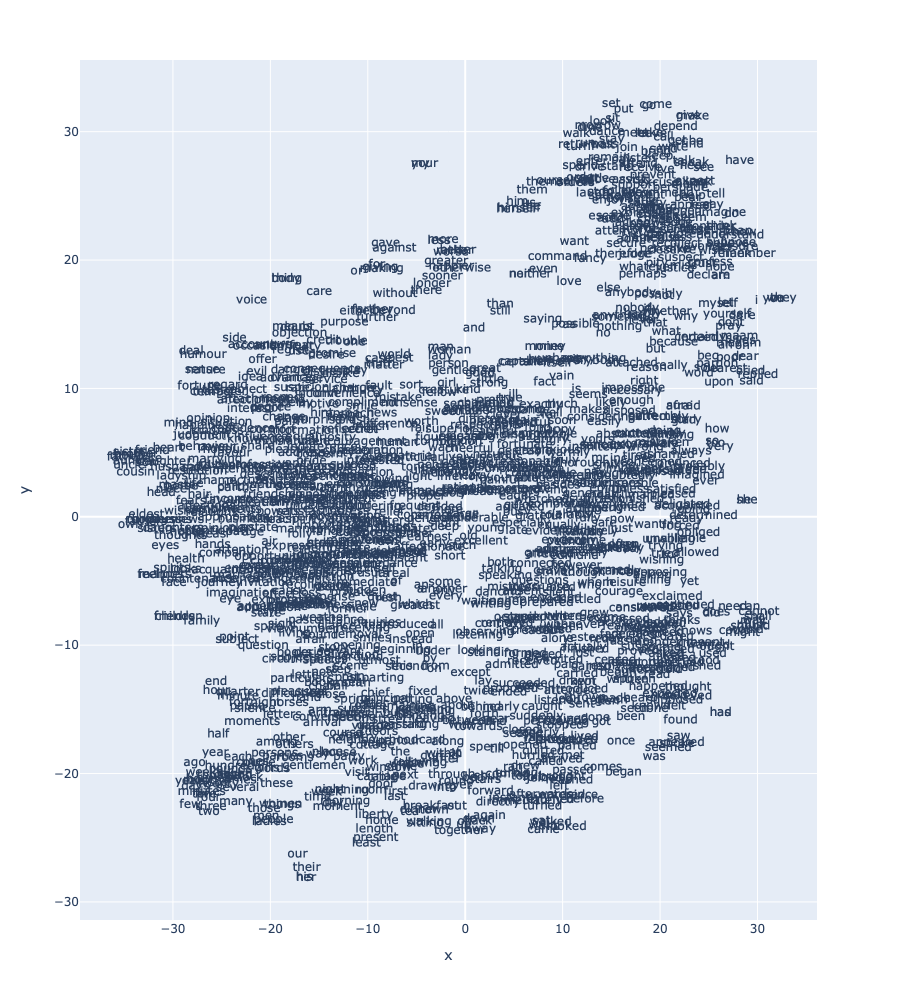

In [100]:
austen.plot_tsne()

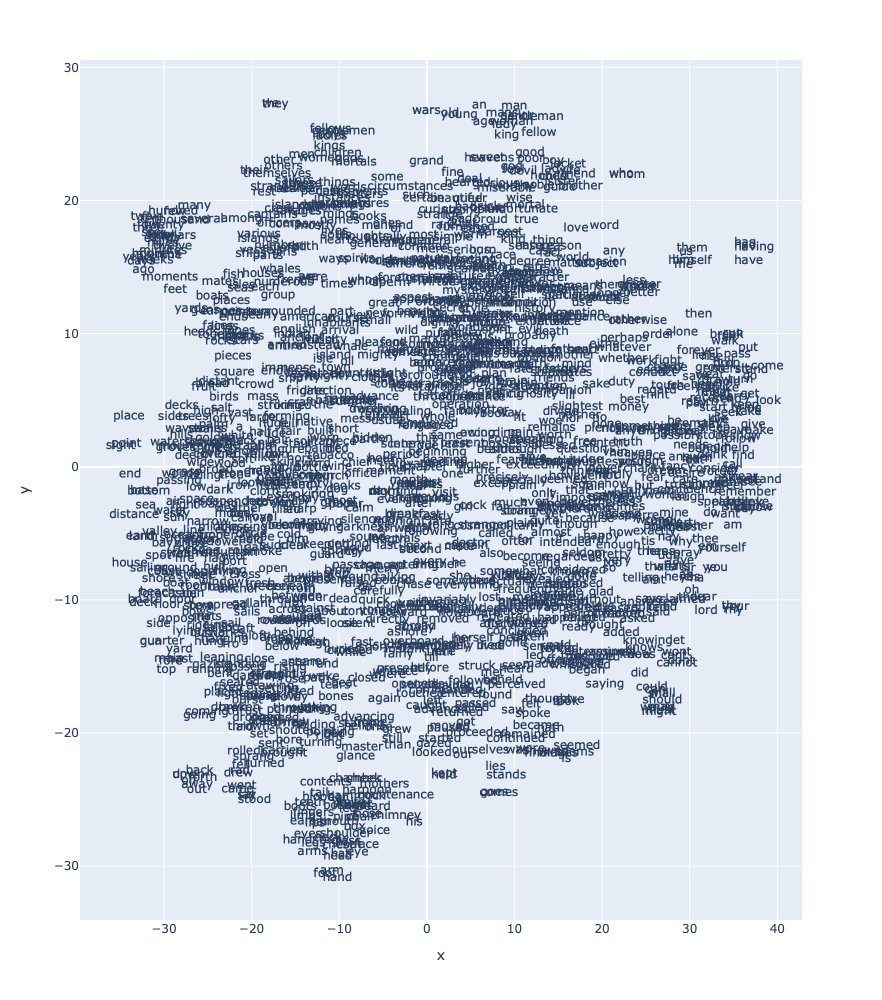

In [101]:
melville.plot_tsne()

# Compute Analogies

$A : B :: C : D? \rightarrow B - A + C = D$


In [102]:
austen.complete_analogy('woman','joy','man', 5)

term       sim
0        civility  0.848098
1     observation  0.836938
2        strength  0.836132
3         history  0.834699
4  disappointment  0.830018

In [103]:
austen.complete_analogy('woman','daughter','man', 5)

term       sim
0      son  0.856947
1     wife  0.839149
2  brother  0.836241
3   sister  0.822136
4    niece  0.818280

In [104]:
melville.complete_analogy('woman','heart','man', 5)

term       sim
0   soul  0.672251
1   body  0.603571
2  death  0.574422
3   book  0.531203
4   mine  0.522235

In [105]:
melville.complete_analogy('man','white','woman', 5)

term       sim
0     red  0.808239
1   black  0.780895
2    tall  0.777055
3  yellow  0.774378
4    thin  0.757574

In [106]:
austen.get_most_similar('joy')

term       sim
0     civility  0.905004
1      history  0.896901
2     strength  0.895212
3   possession  0.885275
4  observation  0.876543
5    composure  0.874886
6   compassion  0.867762
7       warmth  0.866151
8   assistance  0.865134
9    eagerness  0.865099

In [107]:
austen.get_most_similar('woman')

term       sim
0        man  0.946574
1     person  0.878169
2       lady  0.852097
3       girl  0.839346
4  gentleman  0.751991
5   charming  0.748971
6        men  0.745872
7   creature  0.732399
8     fellow  0.723866
9   sensible  0.717699

In [108]:
melville.get_most_similar('man')

term       sim
0  gentleman  0.810805
1     sailor  0.799940
2      woman  0.721518
3       mans  0.719427
4       lady  0.659082
5       king  0.658572
6        age  0.604257
7     seaman  0.590291
8      youth  0.588513
9     fellow  0.586087

In [109]:
melville.get_most_similar('woman')

term       sim
0  gentleman  0.858619
1       lady  0.850151
2     sailor  0.803707
3       girl  0.767350
4        age  0.756444
5     fellow  0.750509
6        god  0.746509
7       fool  0.743763
8       king  0.739553
9     worthy  0.724065

# Save

In [ ]:
# W2V_austen = pd.DataFrame(austen.model.wv.vectors_norm, index=austen.model.wv.vocab.keys())
# W2V_melville = pd.DataFrame(melville.model.wv.vectors_norm, index=melville.model.wv.vocab.keys())

In [ ]:
# W2V_austen.to_csv("{}/{}-W2V-austen.csv".format(data_out, data_prefix))
# W2V_melville.to_csv("{}/{}-W2V-melville.csv".format(data_out, data_prefix))